## Beamprofile (Figure 7)

We are studying the average X-ray beam profile in the focus.

In [1]:
# Import modules
import sys, h5py
import numpy as np
import scipy as sp
%matplotlib notebook

# Import modules from src directory
sys.path.append("../src")
import plotting

In [2]:
# Physical constants
h = 6.62606957e-34 #Js
c = 299792458 #m/s
hc = h*c  #Jm

In [3]:
# Lorentzian
lorentz1d = lambda x, I, gamma: (I * gamma**2) / (x**2 + gamma**2) 

In [4]:
# I/O settings
plotdir = '/Users/benedikt/phd-project/documentation/manuscripts/omrv-paper/manuscript/figures/'

### 1. Loading data from file

In [27]:
# Load size/intensity distribution
results_file = '../analysis/results/results_paper.h5'
with h5py.File(results_file, 'r') as f:
    diameter  = f['diameter'][:]   # nm
    intensity = f['intensity'][:]  # mJ/um2

In [28]:
# Rescale intensity
wavelength = 0.2262 #nm
mJtoPh = lambda i: ((i / 1000.) * wavelength*1e-9) / (hc)  * 1e-12

### 2. Invert intensity data (35 - 45 nm) to get beam profile in the center

In [29]:
# Select size range
size_min, size_max = (35,45)
intensity_profile   = intensity[(diameter > size_min) & (diameter < size_max)]
diameter_profile    = diameter[(diameter > size_min) & (diameter < size_max)]

# Model for beam profile
Ebefore = 3.29 # mJ
transmission = 0.15
s = np.argsort(intensity_profile)[::-1]
pintensity_center = intensity_profile[s]
r_center = np.sqrt((float(Ebefore*transmission) / np.sum(intensity_profile) / np.pi)*np.arange(0,intensity_profile.shape[0]+1))
fwhm_center = r_center[np.argmin(np.abs(pintensity_center - (pintensity_center[0]/2)))]*2 * 1000. # in nm

# Mirror the profile
xmirrored_center = np.hstack([-r_center[:-1][::-1],r_center[:-1]])
ymirrored_center = mJtoPh(np.hstack([pintensity_center[::-1], pintensity_center])) # in Nr. Photons per um2

# Intensity histogram
hist,edges = np.histogram(mJtoPh(intensity_profile), range=(0,0.5), bins=50)

### 3. Invert intensity data (235 - 300 nm) to get beam profile in the tails

In [30]:
# Select size range
size_min, size_max = (235,300)
intensity_profile  = intensity[(diameter > size_min) & (diameter < size_max)]
diameter_profile   = diameter[(diameter > size_min) & (diameter < size_max)]

# Model for beam profile
Ebefore = 3.29 # mJ
transmission = 0.15
s = np.argsort(intensity_profile)[::-1]
pintensity_tails = intensity_profile[s]
r_tails = np.sqrt((float(Ebefore*transmission) / np.sum(intensity_profile) / np.pi)*np.arange(0,intensity_profile.shape[0]+1))
fwhm_tails = r_tails[np.argmin(np.abs(pintensity_tails - (pintensity_tails[0]/2)))]*2 * 1000. # in nm

# Mirror the profile
xmirrored_tails = np.hstack([-r_tails[:-1][::-1],r_tails[:-1]])
ymirrored_tails = mJtoPh(np.hstack([pintensity_tails[::-1], pintensity_tails])) # in Nr. Photons per um2

# Intensity histogram
hist,edges = np.histogram(mJtoPh(intensity_profile), range=(0,0.5), bins=50)

In [35]:
# Combined profile
select_tails  = r_tails[:-1] > 0.68
select_center = r_center[:-1] < 0.7
pintensity_combined = np.hstack([pintensity_center[select_center], pintensity_tails[select_tails]])

# Do normalization on the combined profile
Ebefore = 3.29 # mJ
transmission = 0.01
r_combined = np.sqrt((float(Ebefore*transmission) / np.sum(pintensity_combined) / np.pi)*np.arange(pintensity_combined.shape[0]+1))
fwhm_combined = r_combined[np.argmin(np.abs(pintensity_combined - (pintensity_combined[0]/2)))]*2 * 1000. # in nm
print fwhm_combined, 2*r_combined.max()

# Mirror the profile
xmirrored_combined = np.hstack([-r_combined[:-1][::-1],r_combined[:-1]])
ymirrored_combined = mJtoPh(np.hstack([pintensity_combined[::-1], pintensity_combined])) # in Nr. Photons per um2

126.163390551 0.755066357073


In [32]:
# Resample the combined profile on a regular grid
dx = 1e-3                                                                                                          
x = np.arange(xmirrored_combined.min(), xmirrored_combined.max(), dx)
f = sp.interpolate.interp1d(xmirrored_combined, ymirrored_combined)  
y = f(x)

# Fit single lorentzian to initial beam reconstruction                                                             
popt, pcov = sp.optimize.curve_fit(lorentz1d, x, y)                                                   
Ifit ,gammafit = popt                                                                                              
lfit = lorentz1d(x, Ifit, gammafit) 

### 3. Plotting

<IPython.core.display.Javascript object>


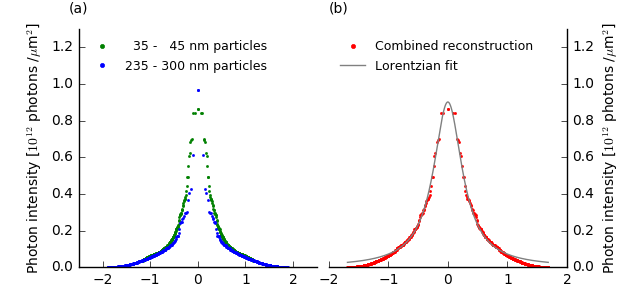

In [33]:
plot = plotting.Plot(rows=1, cols=2, aspect=1, fontsize=10, legend=True, legend_frameon=False, legend_location=2,save_pdf=True)
plot.xlabel = [r'Distance to beam axis [arb. units]', r'Distance to beam axis [$\mu$m]']
plot.ylabel = 2*[r'Photon intensity [$10^{12}$ photons /$\mu$m$^2$]']
plot.title_label = ['', '']

# Plotting the intensity histogram
#plot.plotting_a_histogram(0, hist, edges, label=[''], type='bar', color='r', edgewidth=1)
#plot.axes[0].spines['top'].set_visible(False)
#plot.axes[0].spines['right'].set_visible(False)
#plot.axes[0].set_ylim([0,470])
#plot.axes[0].set_yticks([100,200,300,400])
#plot.axes[0].text(0,485, '(a)', va='bottom', ha='center', fontsize=10, color='k')

# Plotting the beam profile
plot.plotting_traces(0, [xmirrored_center, xmirrored_tails], 
                         [ymirrored_center, ymirrored_tails],
                        ['  35 -   45 nm particles', '235 - 300 nm particles'],
                        colors=['g', 'b'], mecs=['g', 'b'], mfcs=['g', 'b'], linestyles=['None', 'None'],
                        linewidths=[0,0,], markers=['.','.'], markersize=3, logy=False,
                        ylim=[0,1.3], xlim=[-2.5, 2.5])
plot.axes[0].tick_params(axis='y', which='both', right='off', left='on', labelright='off', labelleft='on')
                         #direction='inout', pad=20)
plot.axes[0].tick_params(axis='x', which='both', bottom='on', top='off', labelbottom='on', labeltop='off')
plot.axes[0].yaxis.set_label_position("left")
plot.axes[0].xaxis.labelpad = 7
plot.axes[0].spines['top'].set_visible(False)
plot.axes[0].spines['right'].set_visible(False)
plot.axes[0].text(-2.5,1.45, '(a)', va='top', ha='center', fontsize=10, color='k')
#plot.axes[1].spines['right'].set_position('center')
#plot.axes[1].spines['right'].set_zorder(-1)
#plot.axes[1].spines['right'].set_color('0.5')
#plot.axes[0].set_xticks([-2,-1,0,1,2])
plot.axes[0].set_yticks([0,0.2,0.4,0.6,0.8,1.,1.2])

# Plotting the beam profile
plot.plotting_traces(1, [xmirrored_combined], [ymirrored_combined],
                        ['Combined reconstruction'],
                        colors=['r'], mecs=['r'], mfcs=['r'], linestyles=['None'],
                        linewidths=[0], markers=['.'], markersize=3, logy=False,
                        ylim=[0,1.3], xlim=[-2., 2.])
plot.axes[1].tick_params(axis='y', which='both', right='on', left='off', labelright='on', labelleft='off')
                         #direction='inout', pad=20)
plot.axes[1].tick_params(axis='x', which='both', bottom='on', top='off', labelbottom='on', labeltop='off')
plot.axes[1].yaxis.set_label_position("right")
plot.axes[1].xaxis.labelpad = 7
plot.axes[1].spines['top'].set_visible(False)
plot.axes[1].spines['left'].set_visible(False)
plot.axes[1].text(-2.,1.45, '(b)', va='top', ha='left', fontsize=10, color='k')
#plot.axes[1].spines['right'].set_position('center')
#plot.axes[1].spines['right'].set_zorder(-1)
#plot.axes[1].spines['right'].set_color('0.5')
plot.axes[1].set_xticks([-2,-1,0,1,2])
plot.axes[1].set_yticks([0,0.2,0.4,0.6,0.8,1.,1.2])
#plot.axes[1].text(0.1,1.1, 't=0.15: FWHM=221 nm', fontsize=8, ha='left')
plot.plotting_traces(1, [x], [lfit],
                        ['Lorentzian fit'],
                        colors=['0.5'], mecs=['0.5'], mfcs=['0.5'], linestyles=['-'],
                        linewidths=[1], markersize=1, logy=False,
                        ylim=[0,1.3], xlim=[-2., 2])

#plot.save(plotdir + 'fig_beam_profile.pdf')
plot.show()

**Figure 7.**
(a) Histogram of estimated intensities. 1 bin equals $10^{11}$ photons / $\mu$m$^2$.                                                                                      
(b) Reconstruction of the average X-ray beam profile in the focus based on resorting the estimated photon intensities.                                                             
The injected particles are assumed to uniformly sample the averaged beam profile.

In [34]:
dx = 1e-3                                                                                                          
xsample = np.arange(xmirrored_center.min(), xmirrored_center.max(), dx)                                                                     
#yfit = np.arange(xrecon.min(), xrecon.max(), dx)                                                                     
#xx,yy = np.meshgrid(xfit, yfit)                                                                                    
#rr = np.sqrt(xx**2 + yy**2) 
finterp = sp.interpolate.interp1d(xmirrored_center, ymirrored_center)
ysample = finterp(xsample)
kernel = np.zeros_like(ysample)
#print (np.abs(xmirrored_center)<0.273).sum()
#kernel[:(np.abs(xmirrored_center)<0.273).sum()] = 1.
x = xsample[np.abs(xsample)<(0.25/2.)]
#print 1 - (x)**2
kernel[np.abs(xsample)<(0.25/2.)] = np.sqrt(1 - (x/x.max())**2)
ymirrored_convoluted = np.convolve(ysample, kernel, 'same') / np.sum(kernel)